# PBMC dataset - train reference

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os,sys
import gc
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd

from typing import Union, Optional, Sequence, Any, Mapping, List, Tuple
from anndata import AnnData

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import seaborn as sns
import sklearn
import scipy

import scvi
import torch
device = torch.device("cuda")

sys.path.append('../..')
import q2r_uncertainty.utils
import q2r_uncertainty.q2r_simulation
from q2r_uncertainty.train_models.train_scVI import _train_model,_fit_model

Global seed set to 0


### Load dataset

Merged PBMC datasets (see `./20220531_PBMC_metadata.ipynb`) - normal (healthy)

In [3]:
outpath = '/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/'

In [4]:
adata_normal = sc.read_h5ad(outpath + 'PBMC_merged.normal.subsample500cells.h5ad')

### Cleaning and Quality filtering

In [5]:
## Exclude 3 donors with Smart-seq2 data
adata_normal = adata_normal[adata_normal.obs['assay'] != 'Smart-seq2'].copy()

## Fix dataset naming
adata_normal.obs['dataset_id'] = [x[0] for x in adata_normal.obs['dataset_id'].str.split("_innate")]
adata_normal.obs['dataset_id'] = [x[0] for x in adata_normal.obs['dataset_id'].str.split("_adaptive")]

In [6]:
sc.pp.calculate_qc_metrics(adata_normal, inplace=True)

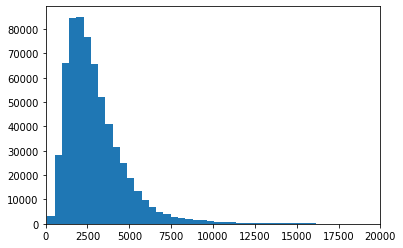

In [7]:
plt.hist(adata_normal.obs['total_counts'], bins=200);
plt.xlim(0,20000);

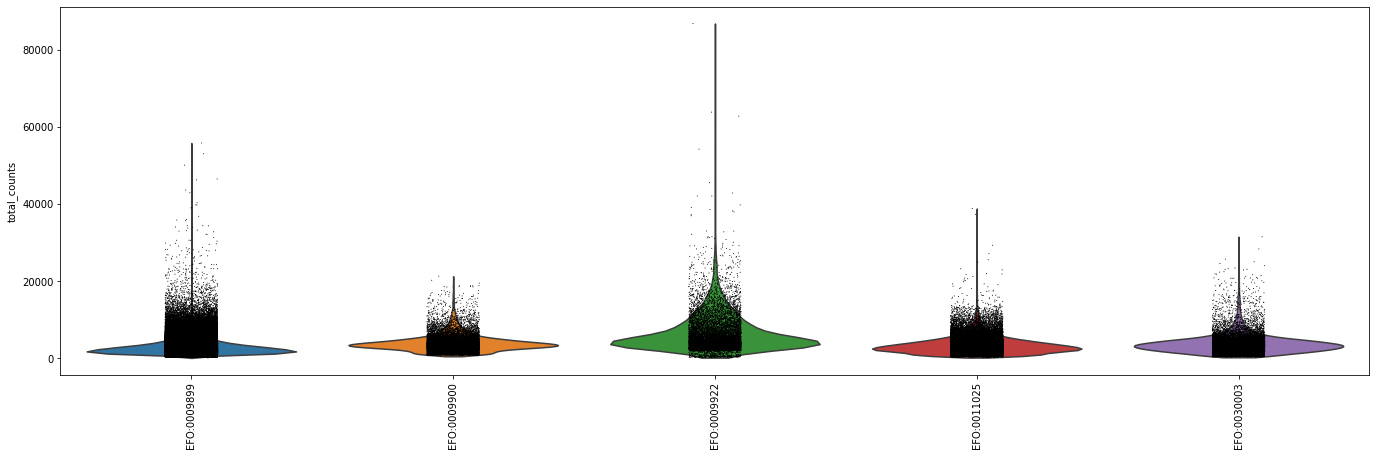

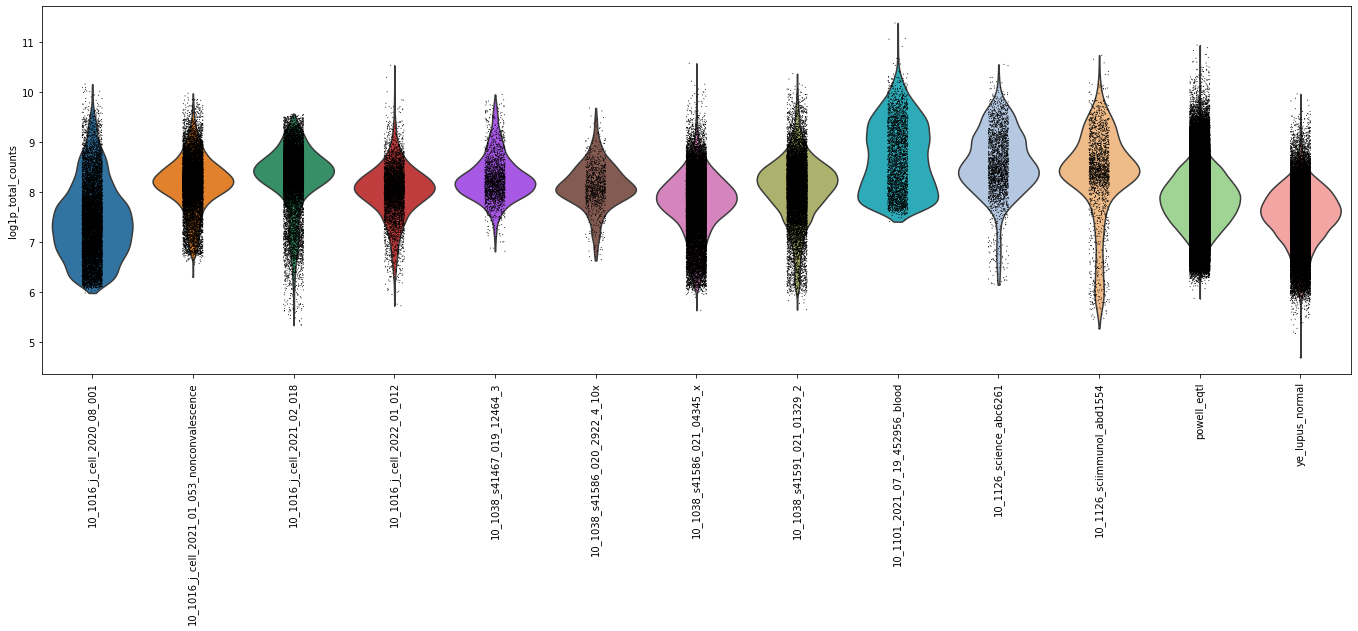

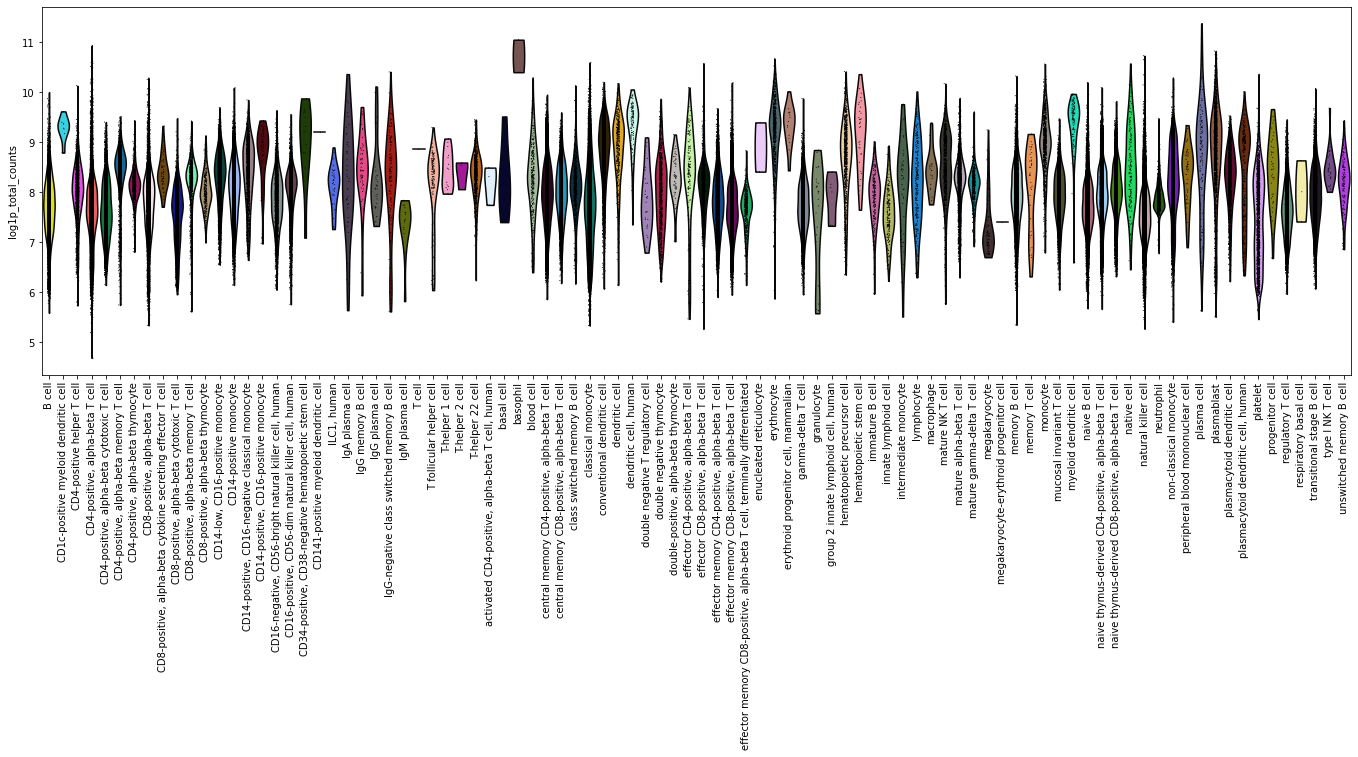

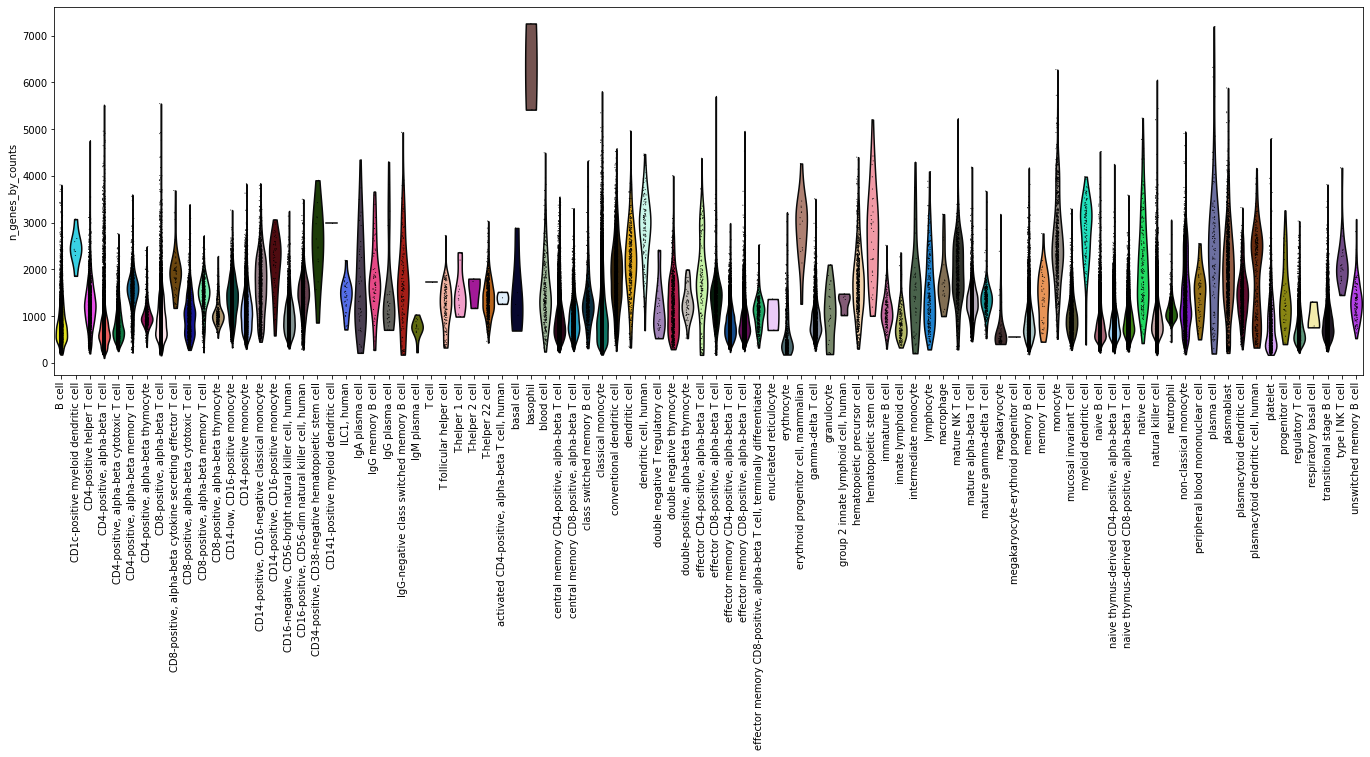

In [8]:
with rc_context({'figure.figsize':[18,7]}):
    sc.pl.violin(adata_normal, 'total_counts', groupby='assay_ontology_term_id', rotation=90)
    sc.pl.violin(adata_normal, 'log1p_total_counts', groupby='dataset_id', rotation=90)
    sc.pl.violin(adata_normal, 'log1p_total_counts', groupby='cell_type', rotation=90)
    sc.pl.violin(adata_normal, 'n_genes_by_counts', groupby='cell_type', rotation=90)

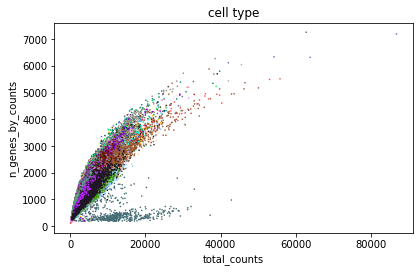

In [9]:
sc.pl.scatter(adata_normal, 'total_counts', 'n_genes_by_counts', size=10, color='cell_type', legend_loc='none')

In [10]:
adata_normal = adata_normal[adata_normal.obs['total_counts'] > 1000].copy()
sc.pp.filter_genes(adata_normal, min_cells=1)

In [13]:
## Make version with fixed cell type names 
def clean_pop_name(string):
    clean = ''.join(e if e.isalnum() else '_' for e in string)
    return('_'.join(clean.split('__')))

adata_normal.obs['cell_type'] = [clean_pop_name(x) for x in adata_normal.obs['cell_type']]

### Train reference model

In [15]:
## Feature selection
adata_normal.layers['counts'] = adata_normal.X.copy()
if 'log1p' not in adata_normal.uns.keys():
    sc.pp.normalize_per_cell(adata_normal)
    sc.pp.log1p(adata_normal)

sc.pp.highly_variable_genes(
    adata_normal,
    n_top_genes=5000,
    subset=True
)

hvgs = adata_normal.var_names.values

In [16]:
adata_normal

AnnData object with n_obs × n_vars = 599379 × 5000
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_id', 'gene_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assay_ontology_term_id_colors', 'dataset_id_colors', 'cell_type_colors', 'log1p', 'hvg'
    layers: 'counts'

In [17]:
## Train scVI model
scvi.model.SCVI.setup_anndata(adata_normal, 
                              batch_key="sample_id", 
                              layer='counts',
                              categorical_covariate_keys=['assay_ontology_term_id']
                             )

arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_normal,
    n_latent=30, 
    gene_likelihood="nb",
    **arches_params
)

vae_ref.train(early_stopping=True,
              train_size=0.9,
              early_stopping_patience=45,
              max_epochs=200,
              batch_size=1024,
              limit_train_batches=20)

adata_normal.obsm["X_scVI"] = vae_ref.get_latent_representation()
vae_ref.save(outpath + "PBMC_merged.normal.subsample500cells_model/", overwrite=True)

INFO     Using batches from adata.obs["sample_id"]                                           
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 599379 cells, 5000 vars, 1255     
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [05:24<00:00,  1.62s/it, loss=1.21e+03, v_num=1]


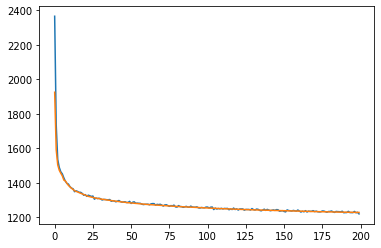

In [18]:
plt.plot(vae_ref.history["elbo_train"])
plt.plot(vae_ref.history["elbo_validation"])

In [19]:
sc.pp.neighbors(adata_normal, n_neighbors=50, use_rep='X_scVI', key_added='scVI')
sc.tl.umap(adata_normal, neighbors_key='scVI')

In [20]:
adata_normal.write_h5ad(outpath + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

In [21]:
outpath + 'PBMC_merged.normal.subsample500cells.scVI.h5ad'

'/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/PBMC_merged.normal.subsample500cells.scVI.h5ad'